<a href="https://colab.research.google.com/github/GerardoFesta/3DFER_SE4AI/blob/main/models/3DModels/LandmarkCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
!pip install -q mlflow
!databricks configure --host https://community.cloud.databricks.com/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
Username: gfesta24@gmail.com
Password: 
Repeat for confirmation: 


In [3]:

import sys
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import numpy as np

In [4]:
train_df = pd.read_csv("/content/drive/Shareddrives/Datasets SEFAI/training_set.csv")
test_df = pd.read_csv("/content/drive/Shareddrives/Datasets SEFAI/test_set.csv")

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Questo commento serve per provare il funzionamento dei commit con colab

batch_size = 64

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X_array, Y_array, transform=None):
        self.X = X_array
        self.Y = Y_array
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        label = self.Y[index]

        # Esegui le trasformazioni se definite
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [7]:

test_df['landmarks'] = test_df['landmarks'].apply(lambda lab: eval(lab))

train_df['landmarks'] = train_df['landmarks'].apply(lambda lab: eval(lab))
print(train_df)

                                      nome  \
0        train/angry/Training_12391352.jpg   
1        train/angry/Training_52407046.jpg   
2        train/angry/Training_20666200.jpg   
3        train/angry/Training_11533347.jpg   
4        train/angry/Training_60003551.jpg   
...                                    ...   
26700  train/disgust/Training_63164084.jpg   
26701  train/disgust/Training_25610374.jpg   
26702  train/disgust/Training_67023235.jpg   
26703  train/disgust/Training_61032772.jpg   
26704  train/disgust/Training_96306068.jpg   

                                               landmarks    label  
0      [[0.5751925706863403, 0.5731657147407532, -0.1...    angry  
1      [[0.43962034583091736, 0.7553703784942627, -0....    angry  
2      [[0.6029075384140015, 0.5643556118011475, -0.0...    angry  
3      [[0.5550940036773682, 0.7429446578025818, -0.0...    angry  
4      [[0.5235995054244995, 0.8211154937744141, -0.0...    angry  
...                                    

In [8]:
print(type(train_df.at[0,"landmarks"]))

label_dict = {"angry":0, "sad": 1, "neutral": 2, "surprise": 3, "disgust": 4, "fear": 5, "happy": 6}

test_df['label'] = test_df['label'].apply(lambda lab: label_dict[lab])

train_df['label'] = train_df['label'].apply(lambda lab: label_dict[lab])

array_train = train_df['landmarks'].to_numpy()
X_train = np.stack([np.array(lst) for lst in array_train])
y_train = train_df['label'].to_numpy()
array_test = test_df['landmarks'].to_numpy()
X_test = np.stack([np.array(lst) for lst in array_test])
y_test = test_df['label'].to_numpy()

<class 'list'>


In [9]:
train_dataset = CustomDataset(X_train, y_train, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = CustomDataset(X_test, y_test, transform=transforms.ToTensor())

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print( X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(26705, 478, 3) (26705,) (6678, 478, 3) (6678,)


In [10]:
def accuracy(preds, labels):
  probabilities = torch.nn.functional.softmax(preds, dim=1)
  _, predicted = torch.max(probabilities, dim=1)
  n_correct = (predicted==labels).sum().float()

  acc =n_correct / labels.shape[0]
  acc= torch.round(acc*100)
  return acc, n_correct;

In [11]:


class LandmarkCNN(nn.Module):
    def __init__(self):
        super(LandmarkCNN, self).__init__()

        self.conv1 = nn.Conv1d(3, 32, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn1 = nn.BatchNorm1d(32, dtype=torch.float64)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn2 = nn.BatchNorm1d(64, dtype=torch.float64)

        self.pool = nn.MaxPool1d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn3 = nn.BatchNorm1d(128, dtype=torch.float64)

        self.conv4 = nn.Conv1d(128, 128, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn4 = nn.BatchNorm1d(128, dtype=torch.float64)

        self.dropout2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv1d(128, 256, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn5 = nn.BatchNorm1d(256, dtype=torch.float64)

        self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn6 = nn.BatchNorm1d(256, dtype=torch.float64)

        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * 59, 256, dtype=torch.float64)
        self.bn7 = nn.BatchNorm1d(256, dtype=torch.float64)

        self.dropout4 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 7, dtype=torch.float64)

    def forward(self, x):
        x = x.view(-1, 3, 478)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.LeakyReLU()(x)

        x = self.pool(x)

        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.LeakyReLU()(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = nn.LeakyReLU()(x)

        x = self.pool(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = nn.LeakyReLU()(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = nn.LeakyReLU()(x)

        x = self.pool(x)
        x = self.dropout3(x)
        x=x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.bn7(x)
        x = nn.LeakyReLU()(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

In [ ]:
model = LandmarkCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/gfesta24@gmail.com/LandmarksCNN")



<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1154140902182959', creation_time=1687113740157, experiment_id='1154140902182959', last_update_time=1688038679486, lifecycle_stage='active', name='/Users/gfesta24@gmail.com/LandmarksCNN', tags={'mlflow.experiment.sourceName': '/Users/gfesta24@gmail.com/LandmarksCNN',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'gfesta24@gmail.com',
 'mlflow.ownerId': '1923923806180228'}>

In [ ]:
mlflow.start_run()

mlflow.set_tag("model_name", "ResNet50")
mlflow.log_param("lr", 0.001)
mlflow.log_param("batch_size", 64)

patience = 3

acc_list_train=[]
acc_list_test=[]


n_total_steps = len(train_loader)


best_loss = 100
counter=0
stop=False
num_epochs = 100
for epoch in range(num_epochs):
        model.train()
        print(counter)
        if stop:
          print(stop)
          break
        running_loss = 0.0
        running_acc = 0
        seen = 0
        for images, labels in train_loader:

          images = images.to(device)
          labels = labels.to(device)


          outputs = model(images)

          loss = criterion(outputs, labels)

          _, acc = accuracy(outputs, labels)
          seen +=labels.shape[0]

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          running_acc += acc

        print (f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {running_acc/seen:.4f}')
        acc_list_train.append(running_acc/len(train_loader))
        mlflow.log_metric("train_loss", running_loss / len(train_loader), step=epoch)
        mlflow.log_metric("train_acc", running_acc/seen, step=epoch)
        model.eval()

        tot_corrette = 0
        tot_eseguite = 0
        running_test_loss = 0
        val_loss = 0

        with torch.no_grad():

          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = model(images)
              test_loss = criterion(outputs, labels)
              _, n_corrette=accuracy(outputs, labels)

              running_test_loss += test_loss.item()
              tot_corrette+=n_corrette.item()
              tot_eseguite+=labels.shape[0]

          test_acc=100* (tot_corrette/tot_eseguite)
          val_loss = running_test_loss / len(test_loader)
          acc_list_test.append(test_acc)
          print("Test acc: ", test_acc)
          print("Test loss: ", val_loss)
          mlflow.log_metric("test_acc", test_acc, step=epoch)
          mlflow.log_metric("test_loss", val_loss, step=epoch)


        if val_loss < best_loss:
          print("MIGLIORATO")
          torch.save(model.state_dict(), 'model_weights.pth')
          best_loss = val_loss
          best_model_train_acc=running_acc/seen
          best_model_test_acc=test_acc
          best_model_test_loss=val_loss
          best_model_train_loss=running_loss / len(train_loader)
          counter = 0
          # Salva i pesi del modello se la validation loss è migliorata
          torch.save(model.state_dict(), 'best_model.pt')
        else:
          counter += 1
        # Verifica se raggiunto il criterio di early stopping
          if counter >= patience:
              print(f'Early stopping at epoch {epoch+1}')
              mlflow.set_tag("Epochs_stopped", epoch+1)
              mlflow.log_artifact("best_model.pt")
              mlflow.log_metric("best_test_acc", best_model_test_acc)
              mlflow.log_metric("best_test_loss", best_model_test_loss)
              mlflow.log_metric("best_train_acc", best_model_train_acc)
              mlflow.log_metric("best_train_loss", best_model_train_loss)
              mlflow.end_run()
              stop=True
        print("BEST TEST LOSS: ", best_loss)


0
Epoch [0/100], Loss: 1.5476, Acc: 0.4032
Test acc:  46.55585504642109
Test loss:  1.4000879606131353
MIGLIORATO
BEST TEST LOSS:  1.4000879606131353
0
Epoch [1/100], Loss: 1.4266, Acc: 0.4472
Test acc:  48.39772386942198
Test loss:  1.3239127167453584
MIGLIORATO
BEST TEST LOSS:  1.3239127167453584
0
Epoch [2/100], Loss: 1.3890, Acc: 0.4625
Test acc:  48.742138364779876
Test loss:  1.3259888704156495
BEST TEST LOSS:  1.3239127167453584
1
Epoch [3/100], Loss: 1.3679, Acc: 0.4735
Test acc:  48.08325846061695
Test loss:  1.3555247229467964
BEST TEST LOSS:  1.3239127167453584
2
Epoch [4/100], Loss: 1.3548, Acc: 0.4780
Test acc:  50.119796346211444
Test loss:  1.3018348198260905
MIGLIORATO
BEST TEST LOSS:  1.3018348198260905
0
Epoch [5/100], Loss: 1.3341, Acc: 0.4853
Test acc:  49.17640011979635
Test loss:  1.3115598189246203
BEST TEST LOSS:  1.3018348198260905
1
Epoch [6/100], Loss: 1.3285, Acc: 0.4883
Test acc:  50.26954177897574
Test loss:  1.2805724005890193
MIGLIORATO
BEST TEST LOSS:  

In [ ]:
!pip install mediapipe

In [ ]:

import zipfile


zip_ref = zipfile.ZipFile('/content/drive/Shareddrives/Datasets SEFAI/scraped_pictures.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import mediapipe as mp
import glob, os
import cv2

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

label_dict = {"angry":0, "sad": 1, "neutral": 2, "surprise": 3, "disgust": 4, "fear": 5, "happy": 6}
label_arr=[]
images = []
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:

    for root, dirs, files in os.walk("photos"):
      for dir in dirs:
        if(not dir==".ipynb_checkpoints"):
          label=label_dict[dir]
          for _file in glob.glob("photos/"+dir+"/*.*"):

              image = cv2.imread(_file)
          # Convert the BGR image to RGB before processing.
              #print(_file)
              results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


              annotated_image = image.copy()
              if(results.multi_face_landmarks!=None):
                for face_landmarks in results.multi_face_landmarks:
                  #print('face_landmarks:', face_landmarks)
                  mp_drawing.draw_landmarks(
                      image=annotated_image,
                      landmark_list=face_landmarks,
                      connections=mp_face_mesh.FACEMESH_TESSELATION,
                      landmark_drawing_spec=None,
                      connection_drawing_spec=mp_drawing_styles
                      .get_default_face_mesh_tesselation_style())
                  mp_drawing.draw_landmarks(
                      image=annotated_image,
                      landmark_list=face_landmarks,
                      connections=mp_face_mesh.FACEMESH_CONTOURS,
                      landmark_drawing_spec=None,
                      connection_drawing_spec=mp_drawing_styles
                      .get_default_face_mesh_contours_style())
                  mp_drawing.draw_landmarks(
                      image=annotated_image,
                      landmark_list=face_landmarks,
                      connections=mp_face_mesh.FACEMESH_IRISES,
                      landmark_drawing_spec=None,
                      connection_drawing_spec=mp_drawing_styles
                      .get_default_face_mesh_iris_connections_style())
                points_array = np.array(face_landmarks)

                x_array=[]
                y_array=[]
                z_array=[]

                landmark_matrix = []
                for data_point in face_landmarks.landmark:
                  landmark_matrix.append([data_point.x, data_point.y, data_point.z])

                label_arr.append(label)
                images.append(landmark_matrix)


In [ ]:
images = np.array(images)

In [ ]:
labels = np.array(label_arr)

In [ ]:
scraped_dataset = CustomDataset(images, labels, transform=transforms.ToTensor())

scraped_loader = DataLoader(scraped_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
model = LandmarkCNN()
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()
model.to(device)



# Calcola le metriche sul test dataset
model.eval()  # Imposta il modello in modalità di valutazione (non addestramento)
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in scraped_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
#auc_roc = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
classification_rep = classification_report(test_labels, test_predictions)

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_rep)


Test Metrics:
Accuracy: 0.30517711171662126
Precision: [0.47826087 0.14210526 0.2        0.39705882 0.         0.
 0.65671642]
F1 Score: [0.25       0.23275862 0.13333333 0.45378151 0.         0.
 0.61538462]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.17      0.25        65
           1       0.14      0.64      0.23        42
           2       0.20      0.10      0.13        30
           3       0.40      0.53      0.45        51
           4       0.00      0.00      0.00        74
           5       0.00      0.00      0.00        29
           6       0.66      0.58      0.62        76

    accuracy                           0.31       367
   macro avg       0.27      0.29      0.24       367
weighted avg       0.31      0.31      0.27       367



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [13]:
def get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_id]).sort_values(f"{metric_name}")
    lowest_metric_run = runs.iloc[0]

    run_id = lowest_metric_run.run_id
    artifact_uri = mlflow.get_artifact_uri(run_id)

    artifact_path = f"{artifact_uri}/{artifact_name}"
    return run_id, artifact_path

# Specifica l'ID del tuo esperimento e i nomi delle metrica e dell'artefatto
experiment_id = '1154140902182959'
metric_name = 'metrics.best_test_loss'
artifact_name = 'model_weights'

run_id, artifact_path = get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name)

print("Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:")
print(artifact_path)

Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:
dbfs:/databricks/mlflow-tracking/1154140902182959/ab01274d2848464f903836081d9897e9/artifacts/721b4cf6ccb44ee5954f57825080ba23/model_weights


In [14]:
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path="/content/artefatto")

'/content/artefatto/'

Test Metrics:
Accuracy: 0.5473195567535191
Precision: [0.41770715 0.41658137 0.43522154 0.63968073 0.5        0.35191638
 0.77075522]
F1 Score: [0.42445213 0.39059501 0.52291105 0.67671894 0.05825243 0.16449511
 0.80368612]
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.43      0.42       853
           1       0.42      0.37      0.39      1107
           2       0.44      0.65      0.52      1185
           3       0.64      0.72      0.68       781
           4       0.50      0.03      0.06        97
           5       0.35      0.11      0.16       941
           6       0.77      0.84      0.80      1714

    accuracy                           0.55      6678
   macro avg       0.50      0.45      0.43      6678
weighted avg       0.53      0.55      0.52      6678



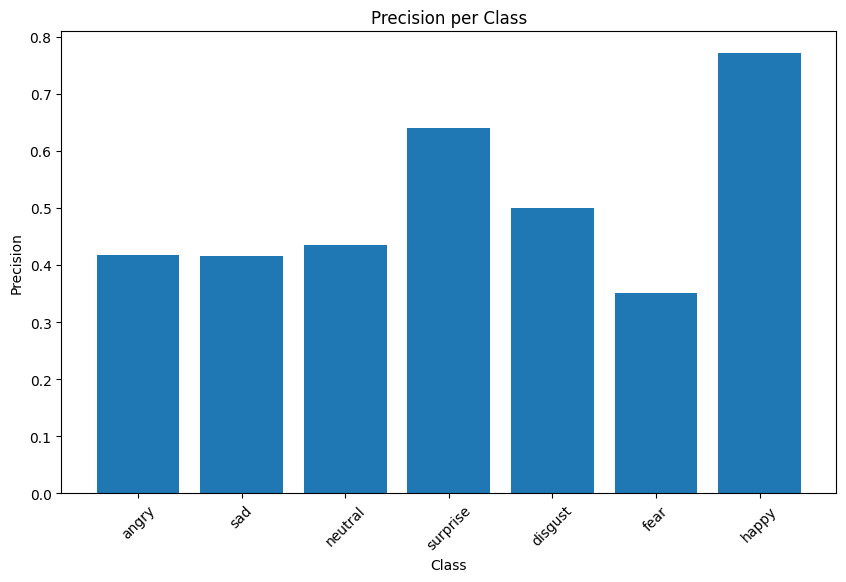

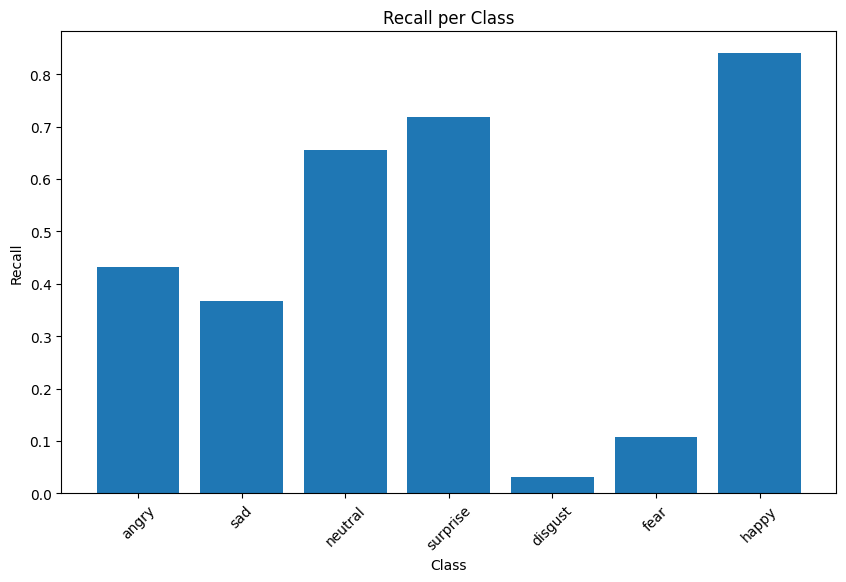

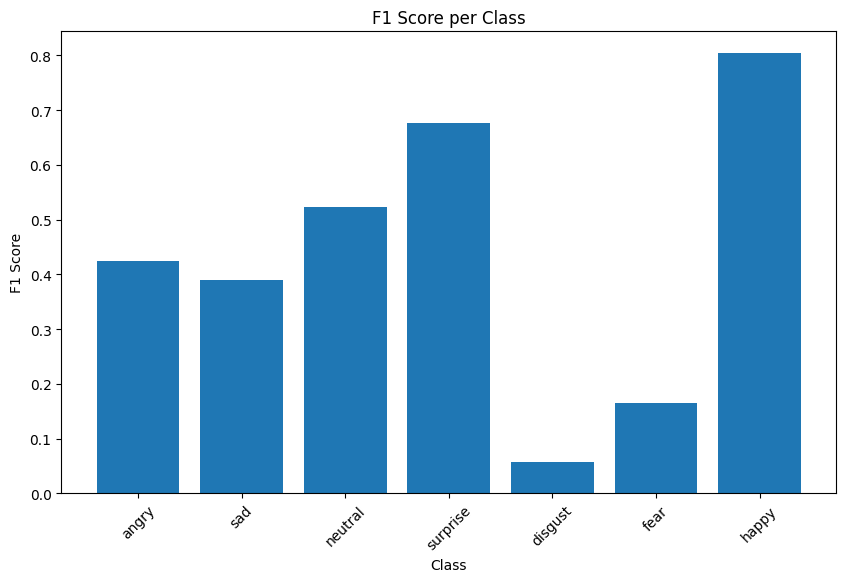

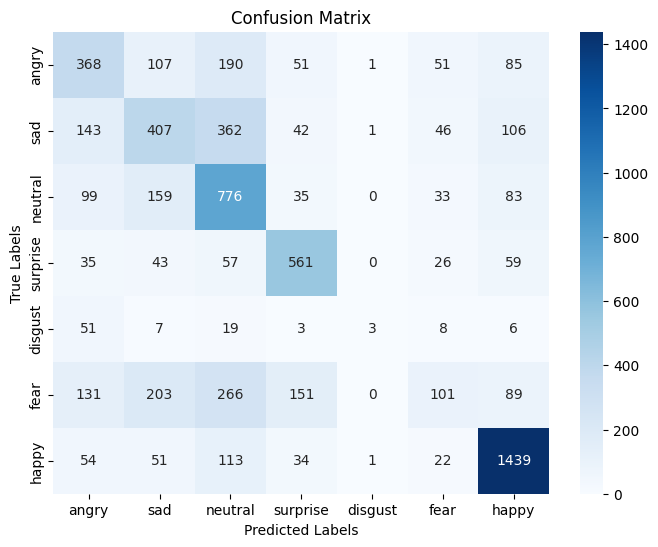

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = LandmarkCNN()
model.load_state_dict(torch.load("/content/artefatto/best_model.pt"))
model.eval()
model.to(device)



# Calcola le metriche sul test dataset
model.eval()  # Imposta il modello in modalità di valutazione (non addestramento)
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
#auc_roc = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
classification_rep = classification_report(test_labels, test_predictions)

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_rep)

# Lista delle etichette delle classi
#class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
class_labels=[9,9,9,9,9,9,9]
for label in ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]:
  class_labels[label_dict[label]]=label




# Crea il grafico a barre per la precisione
plt.figure(figsize=(10, 6))
plt.bar(class_labels, precision)
plt.title('Precision per Class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per il recall
plt.figure(figsize=(10, 6))
plt.bar(class_labels, recall)
plt.title('Recall per Class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per l'F1-score
plt.figure(figsize=(10, 6))
plt.bar(class_labels, f1)
plt.title('F1 Score per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()




# Calcola la matrice di confusione
cm = confusion_matrix(test_labels, test_predictions)

# Crea una figura e un'asse per la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Imposta i nomi delle etichette sulle assi x e y
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Visualizza la matrice di confusione
plt.show()
